# I prepared a dataset of hospital facilities Asthma dismissal records and uploaded it to Carto. 
## download it with an SQL query. Use the function I provide below.
## The name of the DB is NYCAsthmasDismissals
## *within the SQLquery* group the data by zipcode.

In [70]:
import ast
import os
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from scipy.spatial.distance import pdist, squareform

from cStringIO import StringIO
import json
import geopandas as gpd
import pandas as pd
import numpy as np
import pylab as pl

%pylab inline

SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

Populating the interactive namespace from numpy and matplotlib


In [71]:
facilityQuery = '''select zipcodes, count(*) from
(
SELECT * 
FROM  NYCAsthmasDismissals WHERE apr_drg_description ILIKE '%ASTHMA%' 
) t GROUP BY zipcodes'''
    
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilityData
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities

,count,zipcodes
0,1229,10461
1,328,11373
2,1502,10451
3,114,11691
4,145,11375
5,332,10466
6,448,11212
7,44,11229
8,363,11215
9,218,11220


# Find a shape file with zipcode shapes for NYC, download it and open it with geopandas.
# Merge the dataframe with the facility dismissals (the file you got on Carto)  joining on the zipcode and  use the zipcode geometry centers to extract the x and y coordinates of the zipcode center.

In [ ]:
!wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
!unzip application%2Fzip
!mv ZIP* os.getenv("PUIDATA")


In [72]:
zips = gpd.GeoDataFrame.from_file( os.getenv("PUIDATA") + 
                                    '/ZIP_CODE_040114.shx')
zips['zipcodes'] =  zips.ZIPCODE.astype(int)  

merged = zips.merge(facilities, on="zipcodes")

In [73]:
merged.head()

,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry,zipcodes,count
0,29631004.437939,0,Kings,047,62426,Brooklyn,0,0,NY,36,http://www.usps.com/,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",11213,258
1,41972104.071420,0,Kings,047,83866,Brooklyn,0,0,NY,36,http://www.usps.com/,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",11212,448
2,42002738.467230,0,Kings,047,92561,Brooklyn,0,0,NY,36,http://www.usps.com/,11219,"POLYGON ((987286.3515269756 173946.4621963799,...",11219,265
3,55262490.612460,0,Bronx,005,68942,Bronx,0,0,NY,36,http://www.usps.com/,10466,"POLYGON ((1027197.215602726 268941.3607888818,...",10466,332
4,69336166.372634,0,Bronx,005,97932,Bronx,0,0,NY,36,http://www.usps.com/,10467,"POLYGON ((1017396.305742651 265444.4701448828,...",10467,1659


# Create a 3xN numpy array with x-location, y-location, number of dismissals

In [74]:
krigdata = np.zeros((len(merged),3))
krigdata[:,:2] = [[m.centroid.x, m.centroid.y] for m in merged.geometry]
krigdata[:,2] = [c for c in merged['count'].values]
krigdata

array([[  1.00191287e+06,   1.83803113e+05,   2.58000000e+02],
       [  1.00836538e+06,   1.80768945e+05,   4.48000000e+02],
       [  9.85172779e+05,   1.69813485e+05,   2.65000000e+02],
       [  1.02664711e+06,   2.63909290e+05,   3.32000000e+02],
       [  1.02005912e+06,   2.59287518e+05,   1.65900000e+03],
       [  1.02829272e+06,   2.47902428e+05,   1.22900000e+03],
       [  1.01237400e+06,   2.47427241e+05,   5.23000000e+02],
       [  1.00976434e+06,   2.41746681e+05,   5.92000000e+02],
       [  1.00535896e+06,   2.38316068e+05,   1.50200000e+03],
       [  1.00461252e+06,   2.20393721e+05,   9.20000000e+01],
       [  1.03375196e+06,   2.13025445e+05,   4.74000000e+02],
       [  1.00620449e+06,   1.95763534e+05,   8.95000000e+02],
       [  1.00021475e+06,   1.95030042e+05,   3.16000000e+02],
       [  9.87194513e+05,   1.92431928e+05,   6.96000000e+02],
       [  9.89857162e+05,   1.81769963e+05,   3.63000000e+02],
       [  1.00248639e+06,   1.75967925e+05,   1.2790000

Text(0,0.5,u'Northing (m)')

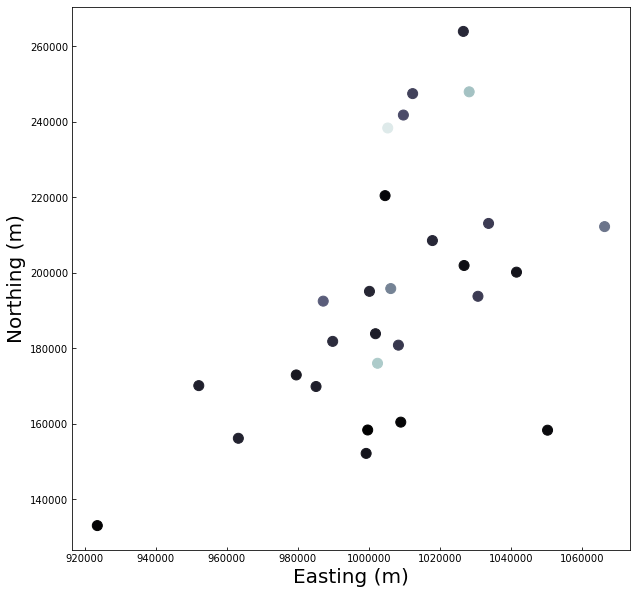

In [75]:
pl.figure(figsize=(10,10))
pl.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='bone')
pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)


# Create and try to model the semi-variogram as we did in class
# https://github.com/fedhere/UInotebooks/blob/master/kriging/kriging_porosity.ipynb
# Explain what is going on

In [76]:

def SVh_vctzd( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N
    #print np.triu_indices(N)
    Z = np.zeros((N,N))
    Z = Z - P[:,2]
    #print Z
    Z = Z.T + P[:,2]
    #print Z
    Z = Z**2
    #print Z
    Zcd =  Z[(pdsv >= h - bw) * (pdsv <= h + bw) * \
            (~np.identity(N, dtype=bool))]

    #print Zcd
    return np.sum( Zcd ) / ( 2.0 * len( Zcd ) )



def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T


Text(0.5,1,u'Sample Semivariogram\nporosity data, lag 5000m')

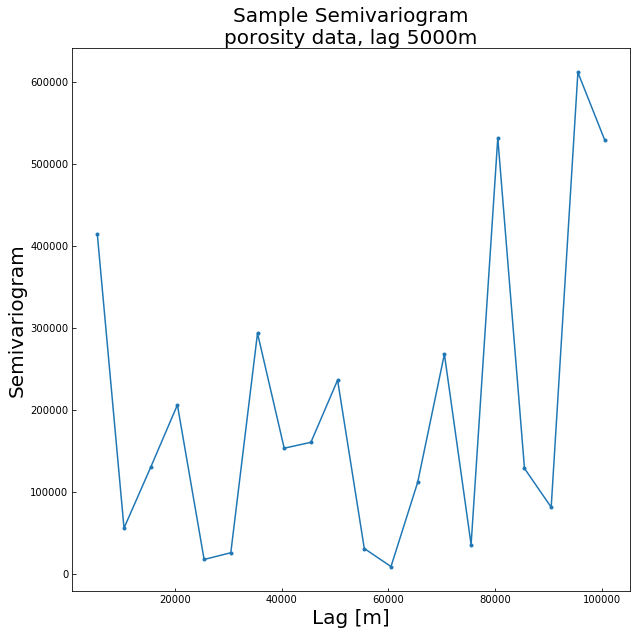

In [78]:
# lags in 5000 meter increments from zero to 100,000
lag = 5000
hs = np.arange(500, 105000, lag)
mysv = SV( krigdata, hs, 500 )


#mysv = SV( x, hs, bw )
pl.figure(figsize=(10,10))
plot( mysv[0], mysv[1], '.-' )
pl.xlabel('Lag [m]', fontsize=20)
pl.ylabel('Semivariogram', fontsize=20)
pl.title('Sample Semivariogram\nporosity data, lag %dm'%lag, fontsize=20) 

Figure 2: The semivariogram of Asthma related discharges from NYC hospitals. The semivariogram indicates that there is no conerent structure (high variations int he variogram value that do not indicate structure of growth, or decrease). Since the semivariogram indicates how similar points are as a function of  and no dependence of counts of discharges on distance between locations of hospitals. This makes sense because we have not accounted for 
1) the size of the hospital
2) the kind of hospital (women's hospitals, childeren hospitals etc')
3) the density of hospitals in the neighborhood. 

This variogram cannot be modelled with a function that would indicate the spacial coherence of the observable (counts) and therefore this data CANNOT and SHOULD NOT be krigged!